# JDAC: G7 Data Scientist: Technical Exercise

## Task

One of the Government’s key objectives is to improve public health. A senior decision maker wants to encourage people to exercise, and is interested in increasing the number of BikePoints (i.e cycle docking stations) in London’s bike sharing scheme:

https://en.wikipedia.org/wiki/Santander_Cycles

You have been asked to analyse the data in this space and present your findings to this decision
maker.
1. Please spend approximately four hours on this technical exercise.
2. Produce a short presentation of at most 5 slides on your findings. The APIs are rate limited and therefore we do not need you to demonstrate working with large volumes of data.
3. Produce a Minimum Viable Product of something that the decision maker would find useful

## Summary

This notebook highlights my approach to this task. Firstly, I investigated the current state of BikePoints in London. I did this by utilising the TfL API **[1]** to extract the number of cycle docks at various points across London. I visualised this. Secondly, I identified the percentage of adults (aged 18+) that are classified as overweight or obese, based on Public Health England Obesity profiles **[2]**. Lastly, by overlaying the current state of BikePoints on top of the obesity data it is possible to make an initial assessment on where to add the new cycle docking stations.

## Research and other considerations
It should be noted that increasing the BikePoints alone would not encourage people to exercise. Evidence suggests that increase in cycling in London has come from existing cyclists cycling more often rather than a net increase in the number of cyclists **[3]**. The introduction of over 50 miles of cycling path in Seville, Spain, has resulted in a 11-fold increase in cycling **[4]**. Perhaps the latter activity could be more fruitful. Additionally, TfL has some requirements when considering the installation of new BikePoints **[5]**, including: <br>
1. Propensity to cycle in the immediate area
2. Location proximity to other cycle stations
3. Financial sustainability

**Sources:** <br>
[1] https://api-portal.tfl.gov.uk/api-details#api=BikePoint&operation=BikePoint_GetAll<br>
[2] https://fingertips.phe.org.uk/profile/national-child-measurement-programme/data#page/9/gid/1938133288/pat/402/par/E06000001/ati/3/are/E02002483/iid/93105/age/200/sex/4/cat/-1/ctp/-1/yrr/3/cid/4/tbm/1/page-options/car-do-0_car-ao-0
<br>
[3] https://content.tfl.gov.uk/exploring-the-relationship-between-cycling-leisure-and-utility-trips.pdf <br>
[4] https://www.theguardian.com/cities/2015/jan/28/seville-cycling-capital-southern-europe-bike-lanes <br>
[5] https://www.london.gov.uk/who-we-are/what-london-assembly-does/questions-mayor/find-an-answer/santander-cycles-2

## Import Packages

In [446]:
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ast
import json
import fingertips_py as ftp
import plotly.graph_objs as go
import plotly.express as px

## Current state of BikePoints in London

In [447]:
#Function to interact with the Tfl API to retrieve data about bike points
def get_bikepoint_data():
    url = 'https://api.tfl.gov.uk/BikePoint/'
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        bike_points = response.json()
        return bike_points
    else:
        print(f"Failed to retrieve data: {response.status_code}")
        return None

In [448]:
#Function to extract key-value pairs from 'additionalProperties' in the bike_points data
def extract_properties(properties):
    return {prop['key']: prop['value'] for prop in properties}

In [449]:
#Call the get_bikepoint_data() function and store the data
bike_points_data = get_bikepoint_data()

In [450]:
#Apply extract_properties function to each bike point
for bike_point in bike_points_data:
    bike_point.update(extract_properties(bike_point['additionalProperties']))

#Create the DataFrame
bike_points_df = pd.DataFrame(bike_points_data)

#Drop the 'additionalProperties' column as its data is now flattened
bike_points_df.drop(columns=['additionalProperties'], inplace=True)

#Convert the NbDocks variable to the data type integer. Necessary for plotting
bike_points_df['NbDocks'] = bike_points_df['NbDocks'].astype('int')

For this analysis, four variables from the bike_points_df are important. These include "commonName", "lat", "lon" and "NbDocks". The following lines of code aim to understand whether if there are any null values in these columns.

In [455]:
len(bike_points_df)

796

In [452]:
bike_points_df.describe()

lat         lon     NbDocks
count  796.000000  796.000000  796.000000
mean    51.505865   -0.127341   26.334171
std      0.020218    0.055002    8.794589
min     51.452997   -0.236769    0.000000
25%     51.493024   -0.171309   20.000000
50%     51.508938   -0.128328   24.000000
75%     51.520867   -0.091262   30.000000
max     51.549369   -0.002275   64.000000

The describe function shows that the count value is the same as the length of the bike_points_df dataframe. This indicated that there are no NAs in these variables. 

In [456]:
#Check if there are any NAs in the "commonName" variable.
bike_points_df['commonName'].isna().sum()

0

It has been confirmed that there are no NAs in any of the variables in bike_points_df dataframe that are required for the analysis.

The .shp file for London Boroughs were downloaded from the London Datastore webpage $^*$. <br>
$^*$https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

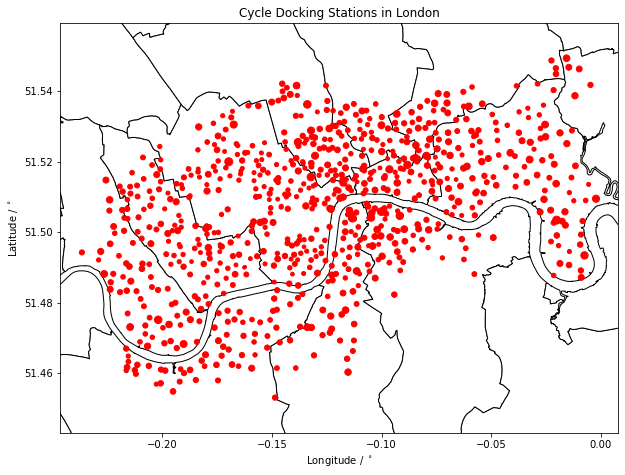

In [432]:
#Load a map of UK and convert it to EPSG:4326, a commonly used coordinate reference system for global maps
london_map = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
london_map = london_map.to_crs(epsg=4326)

# Apply a scaling factor to 'NbDocks' for visual appropriateness
scaling_factor1 = 1  #Adjust this scaling factor as needed
sizes1 = bike_points_df['NbDocks'] * scaling_factor1

#Plotting the map of London
fig1, ax1 = plt.subplots(figsize=(10, 10))
london_map.plot(ax=ax1, color='white', edgecolor='black')

#Set axis limits
padding = 0.01

#Calculate min y, max y, minx and max x. Padding is used for visualisation purposes
min_y = bike_points_df["lat"].min() - padding
max_y = bike_points_df["lat"].max() + padding
min_x = bike_points_df["lon"].min() - padding
max_x = bike_points_df["lon"].max() + padding
    

#Plotting BikePoints as scatter points on the map of London
ax1.scatter(bike_points_df['lon'], bike_points_df['lat'], sizes1, color='red', marker='o')
ax1.set_title('Cycle Docking Stations in London')
ax1.set_xlabel('Longitude / $^\circ$')
ax1.set_ylabel('Latitude / $^\circ$')
ax1.set_ylim((min_y, max_y))
ax1.set_xlim((min_x, max_x))
ax1.set_axis_on()

plt.show()

The depicted plot illustrates the distribution of bicycle docking stations (denoted as NbDocks) across London. By integrating the locations of these docking stations onto a map of London with borough-level detail, one gains a clear understanding of their geographical spread. However, the current representation appears congested. The code provided below aims to refine this presentation, ensuring a more orderly and visually appealing display.

In [402]:
#Function to interact with the the postcodes API to retrieve data about each BikePoints district code. For example,
#River Street, Clerkenwell is in the borough of Islington, corresponding to E09000019.
def get_admin_district(lon, lat):
    url = f"https://api.postcodes.io/postcodes?lon={lon}&lat={lat}"
    response = requests.get(url)
    data = response.json()
    
    #Get the admin_district of the first postcode in the result
    if data['status'] == 200 and data['result']:
        admin_district = data['result'][0]['codes']['admin_district']
    else:
        admin_district = None  #In case there's no result or an error occurs
    
    return admin_district

In [403]:
#Adding a new column 'admin_district' to the bike_points_df DataFrame. This column is populated by applying the 
#get_admin_district function to each row. The function determines the administrative district for each bike point 
#based on its geographic coordinates (longitude and latitude). This is achieved by iterating over all rows in 
#the DataFrame, using the 'apply' method with a lambda function that passes the longitude ('lon') and latitude 
#('lat') of each bike point to get_admin_district.
bike_points_df['admin_district'] = bike_points_df.apply(lambda row: get_admin_district(row['lon'], row['lat']), 
                                                        axis=1)

The following code identifies any missing information in the bike_points_df DataFrame, which may occur if the API call fails to respond for certain longitude and latitude combinations.

In [404]:
#Check if there are any "None" values in bike_points_df
bike_points_df['admin_district'].value_counts(dropna = False) #There are 5 observations where admin_district value is None

admin_district
E09000033    167
E09000030    117
E09000020     93
E09000007     64
E09000022     60
E09000032     59
E09000028     57
E09000013     57
E09000012     39
E09000001     37
E09000019     36
None           5
E09000025      5
Name: count, dtype: int64

In [405]:
#Identify the corresponding index numbers
bike_points_df[bike_points_df['admin_district'].isna()]

$type              id  \
200  Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...  BikePoints_213   
284  Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...  BikePoints_300   
297  Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...  BikePoints_315   
397  Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...  BikePoints_432   
557  Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...  BikePoints_601   

                       url                                   commonName  \
200  /Place/BikePoints_213                   Wellington Arch, Hyde Park   
284  /Place/BikePoints_300               Serpentine Car Park, Hyde Park   
297  /Place/BikePoints_315         The Tennis Courts, The Regent's Park   
397  /Place/BikePoints_432  Exhibition Road Museums 1, South Kensington   
557  /Place/BikePoints_601                   BBC White City, White City   

     placeType children childrenUrls        lat       lon TerminalName  ...  \
200  BikePoint       []           []  51.502740 -0.149569       001109  ...   
284  BikePoint       []           []  51.505014 -0.173060       001217  ...   
297  BikePoint       []           []  51.525367 -0.153463       001199  ...   
397  BikePoint       []           []  51.496468 -0.173796       022158  ...   
557  BikePoint       []           []  51.514767 -0.225787       200136  ...   

    Locked    InstallDate RemovalDate Temporary NbBikes NbEmptyDocks NbDocks  \
200  false  1279537020000                 false       4           29      36   
284  false  1279808700000                 false       5           13      18   
297  false  1279884660000                 false       9            7      16   
397  false  1319448720000                 false       1           12      13   
557  false                                false       2           33      36   

     NbStandardBikes NbEBikes admin_district  
200                3        1           None  
284                5        0           None  
297                9        0           None  
397                1        0           None  
557                2        0           None  

[5 rows x 21 columns]

A manual adjustment is made to address the missing values. I used ONS Open Geography portal$^*$ to identify the admin_district variable based on the *commonName* field in bike_points_df.

$^*$https://geoportal.statistics.gov.uk/datasets/2e9f5c259fec4e1c9951ecb974253c66_0/explore?location=51.467007%2C-0.191993%2C10.45

In [406]:
#Manual adjustments for observations where the postcode.io request returns None
indices = [201, 285, 298, 398, 558]
new_values = ['E09000033', 'E09000033', 'E09000033', 'E09000033', 'E09000013']

#Assigning the new values
for index, value in zip(indices, new_values):
    bike_points_df.loc[index, 'admin_district'] = value

<font color='red'>**WARNING**</font> If an error occurs, please check if the indices with missing admin_district values in bike_points_df match those displayed above.

In [407]:
#Run this code again to verify if the output dataframe is empty, i.e., all observations have a corresponding 
#admin_district.
bike_points_df[bike_points_df['admin_district'].isna()]

$type              id  \
200  Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...  BikePoints_213   
284  Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...  BikePoints_300   
297  Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...  BikePoints_315   
397  Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...  BikePoints_432   
557  Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...  BikePoints_601   

                       url                                   commonName  \
200  /Place/BikePoints_213                   Wellington Arch, Hyde Park   
284  /Place/BikePoints_300               Serpentine Car Park, Hyde Park   
297  /Place/BikePoints_315         The Tennis Courts, The Regent's Park   
397  /Place/BikePoints_432  Exhibition Road Museums 1, South Kensington   
557  /Place/BikePoints_601                   BBC White City, White City   

     placeType children childrenUrls        lat       lon TerminalName  ...  \
200  BikePoint       []           []  51.502740 -0.149569       001109  ...   
284  BikePoint       []           []  51.505014 -0.173060       001217  ...   
297  BikePoint       []           []  51.525367 -0.153463       001199  ...   
397  BikePoint       []           []  51.496468 -0.173796       022158  ...   
557  BikePoint       []           []  51.514767 -0.225787       200136  ...   

    Locked    InstallDate RemovalDate Temporary NbBikes NbEmptyDocks NbDocks  \
200  false  1279537020000                 false       4           29      36   
284  false  1279808700000                 false       5           13      18   
297  false  1279884660000                 false       9            7      16   
397  false  1319448720000                 false       1           12      13   
557  false                                false       2           33      36   

     NbStandardBikes NbEBikes admin_district  
200                3        1           None  
284                5        0           None  
297                9        0           None  
397                1        0           None  
557                2        0           None  

[5 rows x 21 columns]

In [408]:
#Create a new dataframe that groups the observations by the "admin_district" variable. The "NbDocks" variable is 
#summed. In other words, it'll return a dataframe which will include the admin_district and the total cycle docking 
#stations in that corresponding district.
bike_points_grouped_df = bike_points_df.groupby('admin_district')['NbDocks'].sum().reset_index()

In [409]:
#Display the new data frame
bike_points_grouped_df

admin_district  NbDocks
0       E09000001      967
1       E09000007     1714
2       E09000012     1167
3       E09000013     1704
4       E09000019      888
5       E09000020     2134
6       E09000022     1635
7       E09000025      181
8       E09000028     1649
9       E09000030     3339
10      E09000032     1591
11      E09000033     3874

To plot the above as scatter points on a map of London, I will need the 'latitude' and 'longitude'. I therefore leveraged data.gov.uk$^*$ to downloaded the corresponding information as CSV. This information is used to identify the corresponding 'latitude' and 'longitude'.

$^*$ https://www.data.gov.uk/dataset/79dd4d0b-d45e-4491-a786-23bb2339a7c9/local-authority-districts-april-2019-uk-bfc

In [410]:
#Read in the "Local_Authority_Districts_April_2019_UK" dataset
LA_dist_df = pd.read_csv('Local_Authority_Districts_April_2019_UK.csv')

In [411]:
#Rename the 'LAD19CD' column to 'admin_district' to enable a merge
LA_dist_df = LA_dist_df.rename(columns={'LAD19CD': 'admin_district'})

In [412]:
merged_df = pd.merge(bike_points_grouped_df, LA_dist_df, on='admin_district', how='left')

In [413]:
merged_df

admin_district  NbDocks  OBJECTID                 LAD19NM LAD19NMW   BNG_E  \
0       E09000001      967       285          City of London           532382   
1       E09000007     1714       291                  Camden           527492   
2       E09000012     1167       296                 Hackney           534560   
3       E09000013     1704       297  Hammersmith and Fulham           523866   
4       E09000019      888       303               Islington           531158   
5       E09000020     2134       304  Kensington and Chelsea           525757   
6       E09000022     1635       306                 Lambeth           531118   
7       E09000025      181       309                  Newham           540721   
8       E09000028     1649       312               Southwark           533945   
9       E09000030     3339       314           Tower Hamlets           536345   
10      E09000032     1591       316              Wandsworth           525152   
11      E09000033     3874       317             Westminster           528268   

     BNG_N      LONG      LAT   Shape__Area  Shape__Length  \
0   181358 -0.093510  51.5156  2.893680e+06    8928.159844   
1   184284 -0.162890  51.5431  2.177532e+07   25878.008581   
2   185787 -0.060450  51.5549  1.905203e+07   25022.776222   
3   177998 -0.217360  51.4874  1.637750e+07   23430.333674   
4   184647 -0.109920  51.5455  1.486356e+07   20475.958422   
5   179053 -0.189760  51.4964  1.213337e+07   20704.009326   
6   175626 -0.113850  51.4644  2.679945e+07   33350.494517   
7   183327  0.027369  51.5313  3.619480e+07   34364.259690   
8   175862 -0.073090  51.4659  2.883519e+07   33302.756820   
9   181451 -0.036400  51.5155  1.977983e+07   27295.738843   
10  174137 -0.200210  51.4524  3.428031e+07   37924.003167   
11  180871 -0.152950  51.5122  2.146590e+07   26909.338193   

                                GlobalID  
0   9c0628c9-6476-4270-b9b3-5d06b21b0030  
1   0ca41777-6893-495d-8c10-5faa1098c458  
2   11d3adda-30a1-4386-9518-b72e83a26628  
3   1f652d7e-22c1-4ecd-a56e-b7728938be65  
4   5180b537-4fca-486c-b13f-1a739a689c1a  
5   0e0f46e6-063b-4d10-a7a5-8ce73f4df122  
6   e1ef415d-0134-4487-b54f-5d2f50c89e3d  
7   b823f6d4-1818-4326-be7f-ec82fb3575ae  
8   9d8e9908-e6b4-4f30-a069-987934f1d5ed  
9   7946b1b3-7d2e-4aa0-ac09-b83494b03cce  
10  b19398c8-c42c-4311-bc6e-74a6b5ad1264  
11  77a69446-3825-49da-a135-4a464f1fdf13

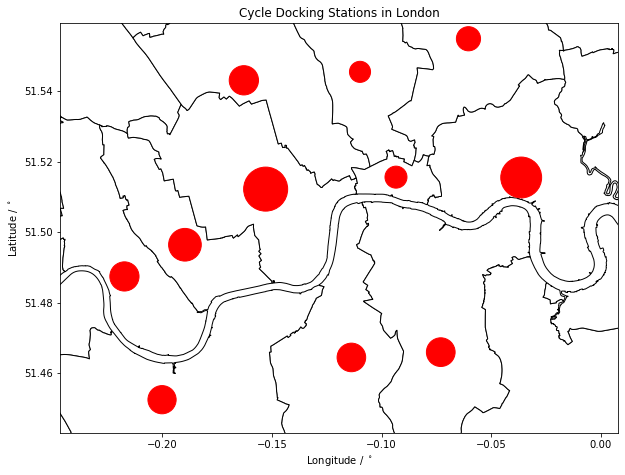

In [443]:
#Apply a scaling factor to 'NbDocks' for visual appropriateness
scaling_factor2 = 0.5  #Adjust this scaling factor as needed
sizes2 = merged_df['NbDocks'] * scaling_factor2

#Plotting
fig2, ax2 = plt.subplots(figsize=(10, 10))
london_map.plot(ax=ax2, color='white', edgecolor='black')
ax2.scatter(merged_df['LONG'], merged_df['LAT'], sizes2, color='red', marker='o')
ax2.set_title('Cycle Docking Stations in London')
ax2.set_xlabel('Longitude / $^\circ$')
ax2.set_ylabel('Latitude / $^\circ$')
ax2.set_ylim((min_y, max_y))
ax2.set_xlim((min_x, max_x))
ax2.set_axis_on()

plt.show()

The provided plot offers a visual representation of the distribution of bicycle docking stations, referred to as NbDocks, throughout the London boroughs. Compared to previous visualizations, this plot achieves a reduced level of clutter, enhancing readability and enabling easier identification of boroughs hosting a higher concentration of cycle docking stations. Nonetheless, the plot may not accurately depict the geographical nuances of certain boroughs, particularly the proximity of BikePoints to the river. This detail is crucial for comprehensive spatial analysis, yet the current illustration fails to communicate it effectively.

## Percentage of Adults (18+) Classified as Obese in London Boroughs

The subsequent component of the analysis involves examining obesity rates across London's boroughs. This examination is crucial for identifying potential locations for new BikePoints, as it provides insight into areas where the introduction of additional cycling infrastructure could significantly impact public health.

In [415]:
#Extract data from the fingertips_py package. The indicator_id of interest is 93088 which refers to percentage
#of adults (aged 18 plus) classified as overweight or obese
obesity_data = ftp.get_data_for_indicator_at_all_available_geographies(93088)

The fingertips_py package was observed to cause issues. If this persists, use the API instead. The url of interest is https://fingertips.phe.org.uk/api/all_data/csv/by_indicator_id?indicator_ids=93088. The data must be filtered afterwards.

Check all relevant variables within obesity_data_filtered for NAs. The relvant variables include "Area Type", "Time period", "Area Code" and "Value".

In [460]:
#Determine the length of obesity_data
len(obesity_data)

16835

In [464]:
#Determine if there are any NAs in the "Area Type" column in the obesity_data dataframe
obesity_data["Area Type"].isna().sum()

0

In [467]:
#Determine if there are any NAs in the "Time period" column in the obesity_data dataframe
obesity_data["Time period"].isna().sum()

0

In [465]:
#Determine if there are any NAs in the "Area" column in the obesity_data dataframe
obesity_data["Area Code"].isna().sum()

0

In [458]:
#Describe numerical data within the obesity_data dataframe
obesity_data.describe()

Indicator ID         Value  Lower CI 95.0 limit  Upper CI 95.0 limit  \
count       16835.0  16835.000000         16835.000000         16835.000000   
mean        93088.0     62.419402            58.373868            66.421002   
std             0.0      6.152278             6.402957             6.093588   
min         93088.0     31.167510            27.956990            34.289130   
25%         93088.0     59.032395            54.721550            62.876250   
50%         93088.0     62.897650            59.101650            66.746410   
75%         93088.0     66.517590            62.781400            70.618560   
max         93088.0     77.612230            73.659670            81.351980   

       Lower CI 99.8 limit  Upper CI 99.8 limit  Count    Denominator  \
count         16835.000000         16835.000000    0.0   16835.000000   
mean             56.042435            68.661478    NaN    2075.198990   
std               6.632847             6.135825    NaN    9281.952873   
min              26.045280            35.136660    NaN     160.000000   
25%              52.073730            64.943820    NaN     412.000000   
50%              56.842110            68.956040    NaN     430.000000   
75%              60.671460            72.931305    NaN     477.000000   
max              72.014480            83.682980    NaN  170273.000000   

       Value note  Time period Sortable  New data  Compared to goal  
count         0.0          1.683500e+04       0.0               0.0  
mean          NaN          2.018000e+07       NaN               NaN  
std           NaN          2.000059e+04       NaN               NaN  
min           NaN          2.015000e+07       NaN               NaN  
25%           NaN          2.016000e+07       NaN               NaN  
50%           NaN          2.018000e+07       NaN               NaN  
75%           NaN          2.020000e+07       NaN               NaN  
max           NaN          2.021000e+07       NaN               NaN

From the above, it can be seen that all relevant variables do not contain NAs.

In [416]:
#API endpoint URL
url = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-united-kingdom-county-unitary-authority/records?limit=50&refine=rgn_name%3A%22London%22"

#Make the GET request
response = requests.get(url)

#Check if the request was successful
if response.status_code == 200:
    #Parse JSON response
    london_la_data = response.json()
else:
    print("Failed to retrieve data:", response.status_code)

The aforementioned procedure is designed to retrieve information pertinent to all London boroughs, specifically capturing each borough's name and its administrative district code. This data will be instrumental in refining the obesity dataset, ensuring that it exclusively encompasses obesity statistics corresponding to all London boroughs.

In [417]:
results = london_la_data.get('results', [])

#Extract the relevant information from each entry in the results list
extracted_data = [{
    'ctyua_code': result.get('ctyua_code', ''),
    'ctyua_name': result.get('ctyua_name', ''),
    'ctyua_type': result.get('ctyua_type', '')
} for result in results]

#Convert the list of dictionaries to a DataFrame
london_la_data_df = pd.DataFrame(extracted_data)

In [418]:
london_la_data_df

ctyua_code                ctyua_name      ctyua_type
0   [E09000016]                [Havering]  London borough
1   [E09000029]                  [Sutton]  London borough
2   [E09000018]                [Hounslow]  London borough
3   [E09000014]                [Haringey]  London borough
4   [E09000030]           [Tower Hamlets]  London borough
5   [E09000011]               [Greenwich]  London borough
6   [E09000003]                  [Barnet]  London borough
7   [E09000026]               [Redbridge]  London borough
8   [E09000010]                 [Enfield]  London borough
9   [E09000005]                   [Brent]  London borough
10  [E09000012]                 [Hackney]  London borough
11  [E09000020]  [Kensington and Chelsea]  London borough
12  [E09000032]              [Wandsworth]  London borough
13  [E09000017]              [Hillingdon]  London borough
14  [E09000008]                 [Croydon]  London borough
15  [E09000002]    [Barking and Dagenham]  London borough
16  [E09000028]               [Southwark]  London borough
17  [E09000024]                  [Merton]  London borough
18  [E09000004]                  [Bexley]  London borough
19  [E09000025]                  [Newham]  London borough
20  [E09000027]    [Richmond upon Thames]  London borough
21  [E09000001]          [City of London]  London borough
22  [E09000013]  [Hammersmith and Fulham]  London borough
23  [E09000022]                 [Lambeth]  London borough
24  [E09000023]                [Lewisham]  London borough
25  [E09000006]                 [Bromley]  London borough
26  [E09000019]               [Islington]  London borough
27  [E09000033]             [Westminster]  London borough
28  [E09000007]                  [Camden]  London borough
29  [E09000021]    [Kingston upon Thames]  London borough
30  [E09000009]                  [Ealing]  London borough
31  [E09000015]                  [Harrow]  London borough
32  [E09000031]          [Waltham Forest]  London borough

As one can see the 'ctyua_code' variable is not in the correct format. The below steps will address this issue.

In [419]:
#Reformat 'cityua_code' column
london_la_data_df['ctyua_code'] = london_la_data_df['ctyua_code'].astype(str)
london_la_data_df['ctyua_code'] = london_la_data_df['ctyua_code'].apply(lambda x: ast.literal_eval(x)[0] if x else x)

In [420]:
london_la_data_df

ctyua_code                ctyua_name      ctyua_type
0   E09000016                [Havering]  London borough
1   E09000029                  [Sutton]  London borough
2   E09000018                [Hounslow]  London borough
3   E09000014                [Haringey]  London borough
4   E09000030           [Tower Hamlets]  London borough
5   E09000011               [Greenwich]  London borough
6   E09000003                  [Barnet]  London borough
7   E09000026               [Redbridge]  London borough
8   E09000010                 [Enfield]  London borough
9   E09000005                   [Brent]  London borough
10  E09000012                 [Hackney]  London borough
11  E09000020  [Kensington and Chelsea]  London borough
12  E09000032              [Wandsworth]  London borough
13  E09000017              [Hillingdon]  London borough
14  E09000008                 [Croydon]  London borough
15  E09000002    [Barking and Dagenham]  London borough
16  E09000028               [Southwark]  London borough
17  E09000024                  [Merton]  London borough
18  E09000004                  [Bexley]  London borough
19  E09000025                  [Newham]  London borough
20  E09000027    [Richmond upon Thames]  London borough
21  E09000001          [City of London]  London borough
22  E09000013  [Hammersmith and Fulham]  London borough
23  E09000022                 [Lambeth]  London borough
24  E09000023                [Lewisham]  London borough
25  E09000006                 [Bromley]  London borough
26  E09000019               [Islington]  London borough
27  E09000033             [Westminster]  London borough
28  E09000007                  [Camden]  London borough
29  E09000021    [Kingston upon Thames]  London borough
30  E09000009                  [Ealing]  London borough
31  E09000015                  [Harrow]  London borough
32  E09000031          [Waltham Forest]  London borough

The obesity data needs to be prepared. The data obtained from the API is for a range of different types of areas and time period. There is a need to filter it down to the required data set. The 'Area Type' is filtered to 'District & UAs (2020/21)" and the "Time period" is filtered to include just "2021/22" dataset. Subsequently, a mask is applied to extract the obesity data of the London boroughs. Note that a more up to date data is not available for adult obesity.

In [421]:
#Filter the obesity data to zone in on the dataset that we are interested in
obesity_data_filtered = obesity_data[(obesity_data['Area Type'] == 'Districts & UAs (2020/21)') & 
                                     (obesity_data['Time period'] == '2021/22')]

#A mask is applied to extract the data relevant to the London boroughs
obesity_data_filtered = obesity_data_filtered[obesity_data_filtered['Area Code'].isin(la_data_df['ctyua_code'])]

In [422]:
obesity_data_filtered

Indicator ID                                     Indicator Name  \
3051         93088  Percentage of adults (aged 18 plus) classified...   
3052         93088  Percentage of adults (aged 18 plus) classified...   
3053         93088  Percentage of adults (aged 18 plus) classified...   
3054         93088  Percentage of adults (aged 18 plus) classified...   
3055         93088  Percentage of adults (aged 18 plus) classified...   
3056         93088  Percentage of adults (aged 18 plus) classified...   
3057         93088  Percentage of adults (aged 18 plus) classified...   
3058         93088  Percentage of adults (aged 18 plus) classified...   
3059         93088  Percentage of adults (aged 18 plus) classified...   
3060         93088  Percentage of adults (aged 18 plus) classified...   
3061         93088  Percentage of adults (aged 18 plus) classified...   
3062         93088  Percentage of adults (aged 18 plus) classified...   
3063         93088  Percentage of adults (aged 18 plus) classified...   
3064         93088  Percentage of adults (aged 18 plus) classified...   
3065         93088  Percentage of adults (aged 18 plus) classified...   
3066         93088  Percentage of adults (aged 18 plus) classified...   
3067         93088  Percentage of adults (aged 18 plus) classified...   
3068         93088  Percentage of adults (aged 18 plus) classified...   
3069         93088  Percentage of adults (aged 18 plus) classified...   
3070         93088  Percentage of adults (aged 18 plus) classified...   
3071         93088  Percentage of adults (aged 18 plus) classified...   
3072         93088  Percentage of adults (aged 18 plus) classified...   
3076         93088  Percentage of adults (aged 18 plus) classified...   
3077         93088  Percentage of adults (aged 18 plus) classified...   
3078         93088  Percentage of adults (aged 18 plus) classified...   
3079         93088  Percentage of adults (aged 18 plus) classified...   
3080         93088  Percentage of adults (aged 18 plus) classified...   
3081         93088  Percentage of adults (aged 18 plus) classified...   
3082         93088  Percentage of adults (aged 18 plus) classified...   
3083         93088  Percentage of adults (aged 18 plus) classified...   
3084         93088  Percentage of adults (aged 18 plus) classified...   
3085         93088  Percentage of adults (aged 18 plus) classified...   
3086         93088  Percentage of adults (aged 18 plus) classified...   

     Parent Code Parent Name  Area Code               Area Name  \
3051   E92000001     England  E09000001          City of London   
3052   E92000001     England  E09000002    Barking and Dagenham   
3053   E92000001     England  E09000003                  Barnet   
3054   E92000001     England  E09000004                  Bexley   
3055   E92000001     England  E09000005                   Brent   
3056   E92000001     England  E09000006                 Bromley   
3057   E92000001     England  E09000007                  Camden   
3058   E92000001     England  E09000008                 Croydon   
3059   E92000001     England  E09000009                  Ealing   
3060   E92000001     England  E09000010                 Enfield   
3061   E92000001     England  E09000011               Greenwich   
3062   E92000001     England  E09000012                 Hackney   
3063   E92000001     England  E09000013  Hammersmith and Fulham   
3064   E92000001     England  E09000014                Haringey   
3065   E92000001     England  E09000015                  Harrow   
3066   E92000001     England  E09000016                Havering   
3067   E92000001     England  E09000017              Hillingdon   
3068   E92000001     England  E09000018                Hounslow   
3069   E92000001     England  E09000019               Islington   
3070   E92000001     England  E09000020  Kensington and Chelsea   
3071   E92000001     England  E09000021    Kingston upon Thames   
3072   E92000001     England  E09000022          

To display the obesity percentage in a map of london the information regarding "Longitude" and "Latitude" is necessary. We will therefore merge the "london_map" and "obesity_data_filtered" datasets.

In [423]:
obesity_data_final = london_map.merge(obesity_data_filtered, left_on='GSS_CODE', right_on='Area Code')

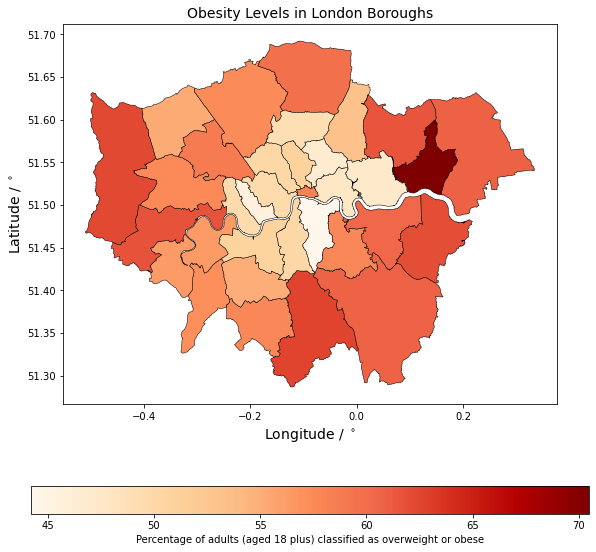

In [442]:
#Plotting
fig3, ax3 = plt.subplots(figsize=(10, 10))

#Plot the color map of obesity values by borough
obesity_data_final.plot(column='Value', ax=ax3, legend=True,
            legend_kwds={'label': "Percentage of adults (aged 18 plus) classified as overweight or obese",
                         'orientation': "horizontal"},
            cmap='OrRd',
            edgecolor='black',  #Color of the border
            linewidth=0.5)  #Line width of borders

#Set title, xlabel and ylabel
ax3.set_title('Obesity Levels in London Boroughs', fontsize = 14)
ax3.set_xlabel('Longitude / $^\circ$', fontsize = 14)
ax3.set_ylabel('Latitude / $^\circ$', fontsize = 14)

plt.show()

To effectively ascertain the locations of existing BikePoints and to facilitate strategic planning for the installation of new BikePoints, I will overlay data pertaining to the number of BikePoints onto the above plot.

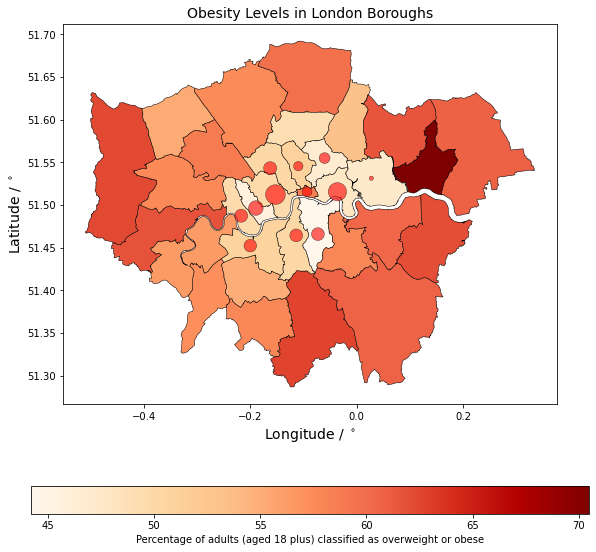

In [437]:
#Apply a scaling factor to 'NbDocks' for visual appropriateness
scaling_factor3 = 0.1
sizes3 = merged_df['NbDocks'] * scaling_factor3

#Plot the color map and scatter plot in one figure
fig4, ax4 = plt.subplots(figsize=(10, 10))

#Plot the color map of obesity values by borough
obesity_data_final.plot(column='Value', ax=ax4, legend=True,
            legend_kwds={'label': "Percentage of adults (aged 18 plus) classified as overweight or obese",
                         'orientation': "horizontal"},
            cmap='OrRd',
            edgecolor='black',  #Color of the border
            linewidth=0.5)  #Line width of borders

#Overlay the scatter plot of locations scaled by 'NbDocks'
ax4.scatter(merged_df['LONG'], merged_df['LAT'], s=sizes3, color='red', alpha=0.6, edgecolor='k', linewidth=0.5)

#Set title, xlabel and ylabel
ax4.set_title('Obesity Levels in London Boroughs', fontsize = 14)
ax4.set_xlabel('Longitude / $^\circ$', fontsize = 14)
ax4.set_ylabel('Latitude / $^\circ$', fontsize = 14)

plt.show()

## Develop an Interactive Visualisation Tool Using Poltly

In [427]:
#I converted the "London_Borough_Excluding_MHW.shp" file into GeoJSON format using the function shown below. It
#has been commented out. The GeoJSON is then loaded in.

#Convert to GeoJSON
#london_map.to_file("statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.geojson", driver='GeoJSON')

#Load GeoJSON
with open("statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.geojson") as geofile:
    geojson = json.load(geofile)

In [445]:
#Create the choropleth map
fig5 = px.choropleth(obesity_data_final,
                    geojson = geojson,
                    locations = 'NAME',  #Column in DataFrame that matches GeoJSON features
                    color = 'Value',     #Column providing the values to color
                    featureidkey = "properties.NAME",  #Path in GeoJSON features to match with 'locations'
                    projection = "mercator",
                    color_continuous_scale='Plasma'  #Define the color scheme
                   )

fig5.update_traces(hovertemplate='Borough = %{location}<br>Percentage Obesity = %{z:.2f}%<extra></extra>')

#Add the scatter plot of locations as an additional layer
fig5.add_trace(
    go.Scattergeo(
        lon = merged_df['LONG'],  #Longitude values
        lat = merged_df['LAT'],   #Latitude values
        text = merged_df['NbDocks'],  #Hover text, i.e., the value we want displayed
        hoverinfo = 'text',
         hovertemplate = 'Number of Docks = %{text}<extra></extra>', #Amend the hovertemplate to state "Number of Docks: ..."
        marker = dict(
            size = merged_df['NbDocks'],  #Use 'NbDocks' to scale the size of the points
            sizemode = 'area',
            sizeref = 2 * max(merged_df['NbDocks'])/(15**2),  #Adjust 15 as needed
            sizemin = 4,  #Minimum size of markers
            color = 'red',  #Color of the points
            line_width = 0
        ),
    )
)

#Addresses the positioning of the colorbar and the title
fig5.update_layout(
    coloraxis_colorbar = dict(
        title='',  #Keep the title blank as I will be adding an annotation for the title
        orientation = 'h', #Shifting from a verticle colorbar to a horizontal one
        y = -0.1, #Moving the colorbar from the top of the plot to the bottom
        len = 0.5,
        thickness = 10
    ),
    title=dict(
    text='Obesity Levels in London Boroughs',
    x=0.5,
    xanchor='center'
    )
)

#The below is a manual adjustment that was required to get the colorbar title to be at the bottom of the bar
fig5.add_annotation(
    x=0.5,
    y=-0.15,
    xref="paper",
    yref="paper",
    text="Percentage of adults (aged 18 plus) classified as overweight or obese",
    showarrow=False,
    font=dict(size=14)
)

fig5.update_geos(fitbounds="locations", visible=False) #Adjust the map's zoom level to area of interest
fig5.show()